# Macro research
## Quantifying geopolitical uncertainty that isn’t yet reflected in the markets


### Introduction

-  The world is currently experiencing more conflicts than at any time since the post-9/11 Iraq war.
-  I believe the risk of nuclear war is at its highest level since the Cold War.
-  Despite these risks, the S&P 500 keeps reaching new highs, driven by the ChatGPT initiated tech boom.
-  Markets seem aware of war risks, as shown by Bitcoin's quick drop when Iran attacked Israel with war drones. S&P 500 did not reflect this drop as it was a Sunday.
-  This leads me to believe that that markets believe AI's economic benefits outweigh the potential negative impacts of war.
-  This study aims to:
  1. Measure the positive effects of AI and negative effects of war on the economy
  2. Analyze how these 2 factors are currently priced into markets
  3. Compare the current situations with the 2000 tech boom and Cold War era to identify possible future scenarios.

### Hypotheses

1. **AI's Economic Impact vs. War Risks**  
   Hypothesis: The S&P 500 and other global indices are more influenced by AI-driven growth trends than by geopolitical risks such as conflicts or war.

   - Test: Analyze correlations between AI-driven tech indices (e.g., NASDAQ Composite or specific AI-related ETFs) and macroeconomic indicators (e.g., GDP, unemployment). Compare these correlations during different periods of conflict.

2. **Bitcoin as a Geopolitical Risk Barometer**  
   Hypothesis: Bitcoin responds more rapidly to geopolitical tensions compared to traditional equity indices due to its decentralized nature.

   - Test: Analyze intraday price movements of Bitcoin and compare them to the S&P 500 during major geopolitical events, such as the Iran-Israel drone attack.

3. **Market Resilience During Conflict**  
   Hypothesis: The current resilience of the S&P 500 to geopolitical shocks is comparable to market behavior during the Cold War and the 2000 Tech Boom, suggesting that technological optimism outweighs geopolitical fears.

   - Test: Compare volatility indices (e.g., VIX) and treasury yields during key geopolitical tensions across the Cold War, 2000 Tech Boom, and post-2022 AI boom.

4. **Geopolitical Risk Premium in Fixed Income**  
   Hypothesis: Treasury yields reflect a greater sensitivity to geopolitical risks compared to equity indices, acting as a haven during periods of heightened tensions.

   - Test: Compare movements in 10-year and 30-year Treasury yields during major geopolitical events with equity indices' performance.

5. **Liquidity Indicators and War Risks**  
   Hypothesis: Increased liquidity injections by central banks during geopolitical crises stabilize markets, reducing immediate impacts of conflict-related news.

   - Test: Compare changes in the Federal Reserve Balance Sheet (WALCL) and Overnight Reverse Repo Agreements (RRPONTSYD) during major conflicts.

### Methodology

1. **Time Period Analysis**  
   Segment the dataset into the predefined periods:  
   - Post-2022 AI Tech Boom  
   - Cold War  
   - 2000 Tech Boom  

   Use these periods to analyze how macroeconomic indicators, equity indices, and fixed-income instruments responded to technological trends and geopolitical risks.

2. **Volatility and Sensitivity Analysis**  
   - Use historical daily returns for indices (`df_yahoo_returns`) to calculate rolling volatilities during conflict periods.  
   - Apply event studies to assess market reactions to major geopolitical events.

3. **Regression Analysis**  
   - Use equity returns (e.g., S&P 500) as the dependent variable and macro indicators (e.g., treasury spreads, inflation, GDP) as independent variables.  
   - Add dummy variables for conflict events to measure their incremental impact.

4. **Scenario Comparisons**  
   - Compare Sharpe ratios, volatility, and drawdowns for indices across the three periods.  
   - Evaluate how liquidity measures and stress indices (e.g., STLFSI) varied during high-conflict periods.

5. **Correlation Analysis**  
   - Assess correlations between Bitcoin and equity indices during geopolitical events.  
   - Compare correlations of growth indicators (e.g., GDP) with equity indices across periods.

6. **Visualizations**  
   - Plot historical returns with time-period-specific shading using `time_period_colors` for intuitive comparison.  
   - Overlay macroeconomic indicators like treasury yields, volatility (VIX), and Bitcoin prices on the same timeline.

### Need to add implied vol options data predicions on spy for forecasts

### DOWNLOAD DATA

In [1]:
import pandas as pd
from yahooquery import Ticker
from fredapi import Fred
import os
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Initialize Yahoo Finance and FRED tickers
yahoo_tickers = {
    # Equity Indices
    "^GSPC": "S&P 500",
    "^N225": "Nikkei 225",
    "^FTSE": "FTSE 100",
    "^HSI": "Hang Seng Index",
    "^IXIC": "Hang Seng Index",

    # Fixed Income
    "^TNX": "10-Year Treasury Yield",
    "^TYX": "30-Year Treasury Yield",
    "^FVX": "5-Year Treasury Yield",
    "^IRX": "13-Week Treasury Bill Yield",

    # Volatility
    "^VIX": "CBOE Volatility Index",

    # Crypto
    "BTC-USD": "Bitcoin_USD",
}

fred_series = {
    # Growth and Employment
    'GDP': 'Gross Domestic Product',
    'UNRATE': 'Unemployment Rate',
    'INDPRO': 'Industrial Production',
    'PAYEMS': 'Nonfarm Payrolls',
    'CIVPART': 'Labor Force Participation Rate',

    # Inflation and Prices
    'CPIAUCSL': 'Consumer Price Index',
    'PPIACO': 'Producer Price Index',
    'PCEPILFE': 'Core PCE Price Index',

    # Trade and Globalization
    'BOPGSTB': 'Trade Balance',
    'DTWEXBGS': 'US Dollar Index',

    # Financial Conditions
    'FEDFUNDS': 'Federal Funds Rate',
    'T10Y2Y': '10-Year Treasury Minus 2-Year Treasury Spread',
    'BAA10Y': 'Moody’s BAA Corporate Bond Yield Spread',
    'STLFSI': 'St. Louis Fed Financial Stress Index',
    
    # Liquidity Indicators
    'WALCL': 'Federal Reserve Balance Sheet',
    'M1SL': 'M1 Money Stock', # NARROW
    'M2SL': 'M2 Money Stock',
    'RRPONTSYD': 'Overnight Reverse Repo Agreements',
    'TOTALSL': 'Total Assets, Liquidity Facilities',
    'DFF': 'Effective Federal Funds Rate'
}

# Initialize data containers
yahoo_data = {}
fred_data = {}

# Fetch data from Yahoo Finance
for ticker, name in yahoo_tickers.items():
    try:
        data = Ticker(ticker)
        history = data.history(period="max")
        if not history.empty:  # Ensure data exists for the ticker
            history['Ticker'] = ticker
            history['Name'] = name
            yahoo_data[ticker] = history
            print(f"Fetched data for {name} ({ticker})")
        else:
            print(f"No data for {name} ({ticker})")
            
    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")

# Fetch data from FRED API (ensure you replace the API key with your own)
fred_api_key = os.getenv('FRED_API_KEY')  # Replace with your FRED API key or set it as an environment variable
fred = Fred(api_key=fred_api_key)

for series_id, series_name in fred_series.items():
    try:
        series_data = fred.get_series(series_id)
        if series_data is not None and not series_data.empty:  # Ensure data exists for the series
            series_df = pd.DataFrame(series_data, columns=['Value'])
            series_df['Ticker'] = series_id
            series_df['Name'] = series_name
            fred_data[series_id] = series_df
            print(f"Fetched data for {series_name} ({series_id})")
        else:
            print(f"No data for {series_name} ({series_id})")
            
    except Exception as e:
        print(f"Error fetching data for {series_name} ({series_id}): {e}")

# Define time periods and their corresponding colors
time_periods = {
    "Post-2022 AI Tech Boom": ("2022-01-01", "2025-01-01"),
    "Cold War": ("1947-01-01", "1991-12-31"),
    "2000 Tech Boom": ("1995-01-01", "2002-12-31")
}
time_period_colors = {
    "Post-2022 AI Tech Boom": "lightblue",
    "Cold War": "lightgreen",
    "2000 Tech Boom": "lightcoral"
}

# Combine Yahoo Finance data into a single DataFrame and save to CSV
if yahoo_data:
    df_yahoo = pd.concat(yahoo_data.values(), ignore_index=False)
    df_yahoo.reset_index(inplace=True)
    df_yahoo.to_csv('yahoo_data.csv', index=False)
else:
    print("No Yahoo Finance data to save.")

# Combine FRED data into a single DataFrame and save to CSV
if fred_data:
    df_fred = pd.concat(fred_data.values(), ignore_index=False)
    df_fred.reset_index(inplace=True)
    df_fred.rename(columns={"index":"date"},inplace=True)
    df_fred.to_csv('fred_data.csv', index=False)
else:
    print("No FRED data to save.")


# Set 'date' as index for easier manipulation
df_yahoo.set_index('date', inplace=True)
df_fred.set_index('date', inplace=True)

# Calculate daily returns for each ticker in df_yahoo (using 'adjclose' column)
tickers_yahoo = df_yahoo['Ticker'].unique()
tickers_fred = df_fred['Ticker'].unique()

# Exclude fixed-income yield tickers for returns calculations
exclude_tickers = ['^TNX', '^TYX',"^FVX","^IRX"]#,"^VIX"] 

# Initialize an empty DataFrame for returns
df_yahoo_returns = pd.DataFrame()

# Loop through tickers_yahoo (the list of tickers you want to process)
for ticker in tickers_yahoo:
    if ticker not in exclude_tickers:  # Only include tickers that are not in the exclude list
        # Filter the dataframe for the current ticker
        ticker_data = df_yahoo[df_yahoo['symbol'] == ticker]
        
        # Calculate percentage change for adjusted close prices and drop NaNs
        df_yahoo_returns[ticker] = ticker_data['adjclose'].pct_change().dropna()

Fetched data for S&P 500 (^GSPC)
Fetched data for Nikkei 225 (^N225)
Fetched data for FTSE 100 (^FTSE)
Fetched data for Hang Seng Index (^HSI)
Fetched data for Hang Seng Index (^IXIC)
Fetched data for 10-Year Treasury Yield (^TNX)
Fetched data for 30-Year Treasury Yield (^TYX)
Fetched data for 5-Year Treasury Yield (^FVX)
Fetched data for 13-Week Treasury Bill Yield (^IRX)
Fetched data for CBOE Volatility Index (^VIX)
Fetched data for Bitcoin_USD (BTC-USD)
Fetched data for Gross Domestic Product (GDP)
Fetched data for Unemployment Rate (UNRATE)
Fetched data for Industrial Production (INDPRO)
Fetched data for Nonfarm Payrolls (PAYEMS)
Fetched data for Labor Force Participation Rate (CIVPART)
Fetched data for Consumer Price Index (CPIAUCSL)
Fetched data for Producer Price Index (PPIACO)
Fetched data for Core PCE Price Index (PCEPILFE)
Fetched data for Trade Balance (BOPGSTB)
Fetched data for US Dollar Index (DTWEXBGS)
Fetched data for Federal Funds Rate (FEDFUNDS)
Fetched data for 10-Yea

In [2]:
# Function to plot all data for a ticker with time periods labeled and differentiated by color
def plot_ticker_with_time_period_labels(ticker_data, time_periods, ticker_names):
    for ticker, data in ticker_data.items():
        # Reset index and ensure date is properly formatted
        if isinstance(data.index, pd.MultiIndex):
            data = data.reset_index()
        if 'date' in data.columns:
            data['date'] = pd.to_datetime(data['date'], utc=True)  # Ensure timezone-aware datetime
            data.set_index('date', inplace=True)

        plt.figure(figsize=(12, 8))
        # Plot all data for the ticker
        plt.plot(data.index, data['adjclose'], label="Adjusted Close Price", color='blue')

        # Add shaded regions for each time period with different colors
        for period_name, (start_date, end_date) in time_periods.items():
            plt.axvspan(pd.Timestamp(start_date, tz='UTC'), pd.Timestamp(end_date, tz='UTC'),
                        alpha=0.3, color=time_period_colors[period_name], label=period_name)

        # Use the actual name of the ticker in the title
        plt.title(f"{ticker_names[ticker]}")
        plt.xlabel("Date")
        plt.ylabel("Adjusted Close Price")
        plt.legend(loc="best")
        plt.grid()
        plt.show()

# Function to plot all data for a FRED series with time periods labeled and differentiated by color
def plot_fred_with_time_period_labels(fred_data, time_periods, fred_names):
    for series_id, data in fred_data.items():
        # Reset index and ensure date is properly formatted
        if isinstance(data.index, pd.MultiIndex):
            data = data.reset_index()
        if 'date' in data.columns:
            data['date'] = pd.to_datetime(data['date'], utc=True)  # Ensure timezone-aware datetime
            data.set_index('date', inplace=True)

        plt.figure(figsize=(12, 8))
        # Plot all data for the FRED series
        plt.plot(data.index, data['Value'], label="Value", color='blue')

        # Add shaded regions for each time period with different colors
        for period_name, (start_date, end_date) in time_periods.items():
            plt.axvspan(pd.Timestamp(start_date, tz='UTC'), pd.Timestamp(end_date, tz='UTC'),
                        alpha=0.3, color=time_period_colors[period_name], label=period_name)

        # Use the actual name of the FRED series in the title
        plt.title(f"{fred_names[series_id]}")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend(loc="best")
        plt.grid()
        plt.show()

In [3]:
# # PLOT YAHOO DATA
# plot_ticker_with_time_period_labels(yahoo_data, time_periods, yahoo_tickers)


In [4]:
# # PLOT FRED MACRO DATA
# plot_fred_with_time_period_labels(fred_data, time_periods, fred_series)


<Figure size 1200x600 with 0 Axes>

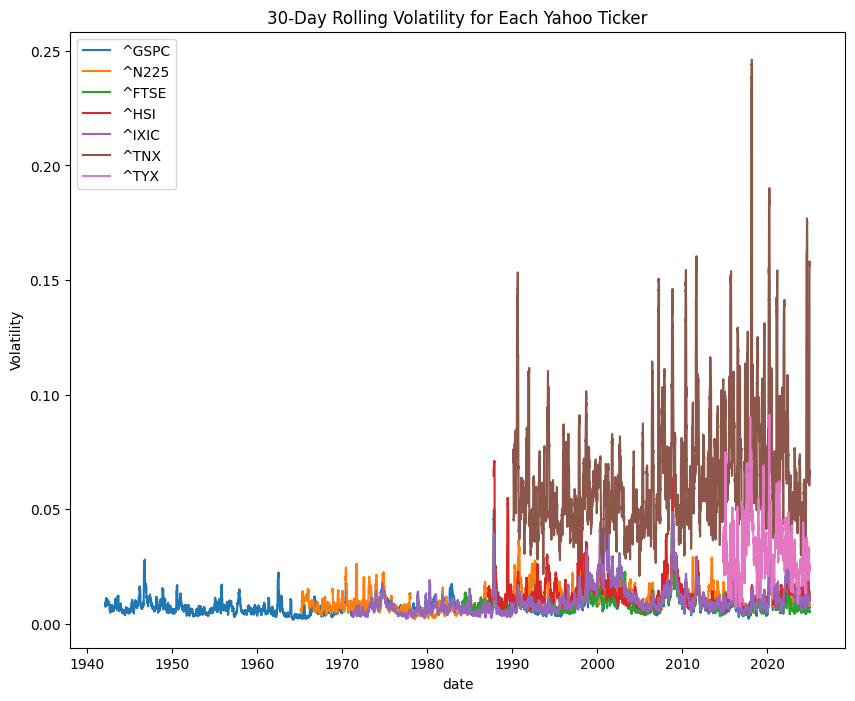

In [5]:
# Plot the returns
plt.figure(figsize=(12, 6))

# Rolling Volatility Calculation (30-Day Window)
rolling_volatility_yahoo = pd.DataFrame()

for ticker in tickers_yahoo:
    if ticker not in exclude_tickers:  # Only include tickers that are not in the exclude list
        ticker_data = df_yahoo[df_yahoo['Ticker'] == ticker]
        rolling_volatility_yahoo[ticker] = ticker_data['adjclose'].pct_change().rolling(window=30).std()

# Plot Rolling Volatility for Each Ticker
rolling_volatility_yahoo.plot(figsize=(10, 8))
plt.title('30-Day Rolling Volatility for Each Yahoo Ticker')
plt.ylabel('Volatility')
plt.legend(tickers_yahoo)
plt.show()


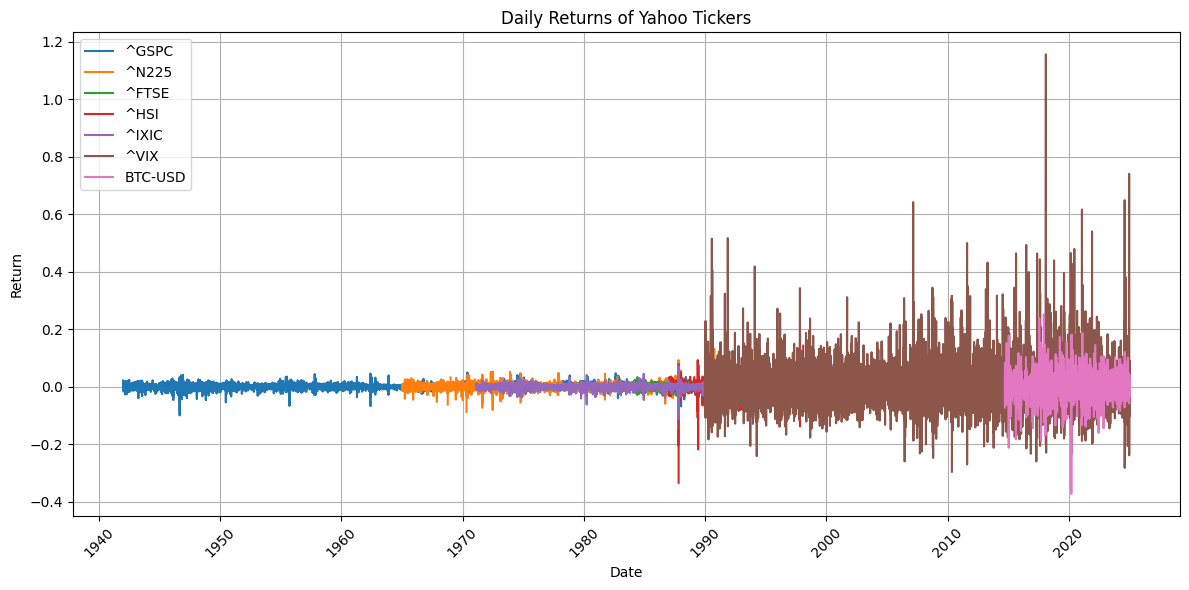

In [6]:
# Plot the returns
plt.figure(figsize=(12, 6))

for column in df_yahoo_returns.columns:
    plt.plot(df_yahoo_returns.index, df_yahoo_returns[column], label=column)

# Customize plot
plt.title('Daily Returns of Yahoo Tickers')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [8]:
def date_filter(df, start_date, end_date):
    """
    Filter a DataFrame by the given date range.
    Assumes the index is a datetime index.
    """
    return df[(df.index >= start_date) & (df.index <= end_date)]

def ensure_datetime_index(df):
    """
    Ensure the index is a timezone-naive datetime index.
    If the index is timezone-aware, convert to UTC and remove the timezone.
    If it's naive, just ensure it's a correct datetime format.
    """
    if isinstance(df.index, pd.DatetimeIndex):
        # If the index has a timezone, remove it (convert to naive)
        if df.index.tz is not None:
            print("Timezone-aware datetime detected. Converting to naive datetime.")
            df.index = df.index.tz_convert('UTC').tz_localize(None)
        else:
            print("Timezone-naive datetime detected.")
            df.index = pd.to_datetime(df.index)  # Ensure it's a valid datetime
    else:
        # If the index is not datetime, convert it to naive datetime
        print("Index is not datetime, converting to naive datetime.")
        df.index = pd.to_datetime(df.index)

    return df

def handle_mixed_datetime(df):
    """
    Handle mixed timezone-aware and timezone-naive datetimes in the DataFrame index.
    Convert all datetimes to timezone-naive.
    """
    if isinstance(df.index, pd.DatetimeIndex):
        if df.index.tz is not None:
            print("Timezone-aware index detected. Converting to naive datetime.")
            df.index = df.index.tz_convert('UTC').tz_localize(None)
        else:
            print("Timezone-naive index detected. Ensuring it's converted to a valid datetime.")
            df.index = pd.to_datetime(df.index)  # Ensure it's valid datetime

    return df

def handle_missing_data(df):
    """
    Handle missing values in the DataFrame.
    - Forward fill missing data.
    - You can customize this with other methods like bfill() or filling with a constant.
    """
    # Check for missing values
    if df.isnull().sum().sum() > 0:
        print(f"Missing data detected. Forward filling missing values.")
        df = df.ffill()  # Forward fill to propagate last valid observation forward
    else:
        print("No missing data detected.")
    
    return df

def analyze_ai_vs_war_impact(df_yahoo_returns, df_fred, time_periods):
    """
    Test Hypothesis 1: AI's Economic Impact vs. War Risks
    """
    # Ensure datetime indices
    df_yahoo_returns = ensure_datetime_index(df_yahoo_returns)
    df_fred = ensure_datetime_index(df_fred)
    
    results = {}
    
    for period_name, (start_date, end_date) in time_periods.items():
        # Filter data for period
        yahoo_period = date_filter(df_yahoo_returns, start_date, end_date)
        fred_period = date_filter(df_fred, start_date, end_date)
        
        # Calculate tech vs non-tech performance
        tech_tickers = ['^IXIC']  # NASDAQ as tech proxy
        market_tickers = ['^GSPC']  # S&P 500 as market proxy
        
        # Check if tickers exist in the data
        available_tech = [t for t in tech_tickers if t in yahoo_period.columns]
        available_market = [t for t in market_tickers if t in yahoo_period.columns]
        
        if available_tech and available_market:
            tech_returns = yahoo_period[available_tech].mean(axis=1)
            market_returns = yahoo_period[available_market].mean(axis=1)
            
            # Get macro indicators
            gdp = fred_period[fred_period['Ticker'] == 'GDP']['Value']
            unemployment = fred_period[fred_period['Ticker'] == 'UNRATE']['Value']
            
            # Calculate correlations if we have enough data
            if not gdp.empty and len(gdp.dropna()) > 1:
                tech_gdp_corr = tech_returns.resample('Q').mean().dropna().corr(gdp.resample('Q').mean().dropna())
                market_gdp_corr = market_returns.resample('Q').mean().dropna().corr(gdp.resample('Q').mean().dropna())
            else:
                tech_gdp_corr = np.nan
                market_gdp_corr = np.nan
            
            results[period_name] = {
                'tech_gdp_correlation': tech_gdp_corr,
                'market_gdp_correlation': market_gdp_corr,
                'tech_returns_mean': tech_returns.mean(),
                'market_returns_mean': market_returns.mean(),
                'tech_volatility': tech_returns.std(),
                'market_volatility': market_returns.std()
            }
        else:
            print(f"Warning: Missing required tickers for period {period_name}")
            results[period_name] = {
                'tech_gdp_correlation': np.nan,
                'market_gdp_correlation': np.nan,
                'tech_returns_mean': np.nan,
                'market_returns_mean': np.nan,
                'tech_volatility': np.nan,
                'market_volatility': np.nan
            }
    
    return pd.DataFrame(results).T

def analyze_bitcoin_response(df_yahoo_returns, geopolitical_events):
    """
    Test Hypothesis 2: Bitcoin as a Geopolitical Risk Barometer
    """
    df_yahoo_returns = ensure_datetime_index(df_yahoo_returns)
    
    results = {}
    window = 5  # Days before and after event
    
    for event_name, event_date in geopolitical_events.items():
        start_date = pd.to_datetime(event_date) - pd.Timedelta(days=window)
        end_date = pd.to_datetime(event_date) + pd.Timedelta(days=window)
        
        event_data = date_filter(df_yahoo_returns, start_date, end_date)
        
        if 'BTC-USD' in event_data.columns and '^GSPC' in event_data.columns:
            btc_response = event_data['BTC-USD']
            sp500_response = event_data['^GSPC']
            
            results[event_name] = {
                'btc_cumulative_return': (1 + btc_response).prod() - 1,
                'sp500_cumulative_return': (1 + sp500_response).prod() - 1,
                'btc_volatility': btc_response.std() * np.sqrt(252),
                'sp500_volatility': sp500_response.std() * np.sqrt(252),
                'reaction_correlation': btc_response.corr(sp500_response)
            }
        else:
            print(f"Warning: Missing required data for event {event_name}")
            results[event_name] = {
                'btc_cumulative_return': np.nan,
                'sp500_cumulative_return': np.nan,
                'btc_volatility': np.nan,
                'sp500_volatility': np.nan,
                'reaction_correlation': np.nan
            }
    
    return pd.DataFrame(results).T

def analyze_market_resilience(df_yahoo, df_fred, time_periods):
    """
    Test Hypothesis 3: Market Resilience During Conflict
    """
    df_yahoo = ensure_datetime_index(df_yahoo)
    df_fred = ensure_datetime_index(df_fred)
    
    results = {}
    
    for period_name, (start_date, end_date) in time_periods.items():
        period_data = date_filter(df_yahoo, start_date, end_date)
        fred_period = date_filter(df_fred, start_date, end_date)
        
        # Get relevant data
        sp500_data = period_data[period_data['symbol'] == '^GSPC']['adjclose']
        vix_data = period_data[period_data['symbol'] == '^VIX']['adjclose']
        treasury_data = fred_period[fred_period['Ticker'] == 'T10Y2Y']['Value']
        
        if not sp500_data.empty:
            # Calculate metrics
            returns = sp500_data.pct_change().dropna()
            drawdown = (sp500_data - sp500_data.expanding().max()) / sp500_data.expanding().max()
            
            results[period_name] = {
                'annualized_volatility': returns.std() * np.sqrt(252),
                'max_drawdown': drawdown.min(),
                'sharpe_ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)),
                'avg_vix': vix_data.mean() if not vix_data.empty else np.nan,
                'avg_treasury_spread': treasury_data.mean() if not treasury_data.empty else np.nan
            }
        else:
            print(f"Warning: Missing required data for period {period_name}")
            results[period_name] = {
                'annualized_volatility': np.nan,
                'max_drawdown': np.nan,
                'sharpe_ratio': np.nan,
                'avg_vix': np.nan,
                'avg_treasury_spread': np.nan
            }
    
    return pd.DataFrame(results).T

def analyze_fixed_income_sensitivity(df_yahoo, df_fred, geopolitical_events):
    """
    Test Hypothesis 4: Geopolitical Risk Premium in Fixed Income
    """
    results = {}
    window = 10  # Days before and after event
    
    for event_name, event_date in geopolitical_events.items():
        start_date = pd.to_datetime(event_date) - pd.Timedelta(days=window)
        end_date = pd.to_datetime(event_date) + pd.Timedelta(days=window)
        
        # Get Treasury yields and spreads using boolean indexing instead of 'between'
        treasury_data = df_yahoo[(df_yahoo.index >= start_date) & (df_yahoo.index <= end_date)]
        fred_data = df_fred[(df_fred.index >= start_date) & (df_fred.index <= end_date)]
        
        # Extract specific treasury symbols and BAA spread
        t10y = treasury_data[treasury_data['symbol'] == '^TNX']['adjclose']
        t2y = treasury_data[treasury_data['symbol'] == '^IRX']['adjclose']
        baa_spread = fred_data[fred_data['Ticker'] == 'BAA10Y']['Value']
        
        # Compute changes and volatility metrics
        results[event_name] = {
            't10y_change': t10y.pct_change().sum() if not t10y.empty else np.nan,
            't2y_change': t2y.pct_change().sum() if not t2y.empty else np.nan,
            'term_spread_change': (t10y - t2y).diff().mean() if not t10y.empty and not t2y.empty else np.nan,
            'baa_spread_change': baa_spread.diff().mean() if not baa_spread.empty else np.nan,
            'yield_volatility': t10y.pct_change().std() * np.sqrt(252) if not t10y.empty else np.nan
        }
    
    return pd.DataFrame(results).T

def analyze_liquidity_impact(df_fred, geopolitical_events):
    """
    Test Hypothesis 5: Liquidity Indicators and War Risks
    """
    results = {}
    window = 30  # Days before and after event
    
    for event_name, event_date in geopolitical_events.items():
        start_date = pd.to_datetime(event_date) - pd.Timedelta(days=window)
        end_date = pd.to_datetime(event_date) + pd.Timedelta(days=window)
        
        # Get liquidity indicators
        #fed_balance_data = date_filter(df_fred, start_date, end_date)['WALCL']
        repo_data = date_filter(df_fred, start_date, end_date)['RRPONTSYD']
        m2_data = date_filter(df_fred, start_date, end_date)['M2SL']
        
        results[event_name] = {
            #'fed_balance_change': fed_balance_data.diff().sum(),
            'repo_change': repo_data.diff().sum(),
            'm2_change': m2_data.diff().sum()
        }
    
    return pd.DataFrame(results).T

def plot_results(ai_war_impact, bitcoin_response, market_resilience, fixed_income_sensitivity):#, liquidity_impact):
    """
    Create visualizations for all hypothesis tests
    """
    plt.figure(figsize=(15, 10))
    
    # Plot AI vs War Impact
    plt.subplot(2, 2, 1)
    ai_war_impact[['tech_gdp_correlation', 'market_gdp_correlation']].plot(kind='bar')
    plt.title('Tech vs Market GDP Correlations')
    plt.xticks(rotation=45)
    
    # Plot Bitcoin Response
    plt.subplot(2, 2, 2)
    bitcoin_response[['btc_cumulative_return', 'sp500_cumulative_return']].plot(kind='bar')
    plt.title('Bitcoin vs S&P 500 Response to Events')
    plt.xticks(rotation=45)
    
    # Plot Market Resilience
    plt.subplot(2, 2, 3)
    market_resilience[['annualized_volatility', 'sharpe_ratio']].plot(kind='bar')
    plt.title('Market Resilience Metrics')
    plt.xticks(rotation=45)
    
    # Plot Fixed Income Sensitivity
    plt.subplot(2, 2, 4)
    fixed_income_sensitivity[['t10y_change', 'baa_spread_change']].plot(kind='bar')
    plt.title('Fixed Income Response to Events')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Liquidity Impact
    plt.figure(figsize=(10, 6))
    # liquidity_impact[['fed_balance_change', 'repo_change', 'm2_change']].plot(kind='bar')
    # plt.title('Liquidity Measures Response to Events')
    fixed_income_sensitivity[['t10y_change', 'baa_spread_change']].plot(kind='bar')
    plt.title('Fixed Income Response to Events')
    plt.xticks(rotation=45)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [9]:
# Apply the data cleaning functions to your DataFrames
try:
    # Handle df_fred, df_yahoo, and df_yahoo_returns
    df_fred = handle_mixed_datetime(df_fred)
    df_yahoo = handle_mixed_datetime(df_yahoo)
    df_yahoo_returns = handle_mixed_datetime(df_yahoo_returns)
    
    # Handle df_fred, df_yahoo, and df_yahoo_returns
    df_fred = ensure_datetime_index(df_fred)
    df_yahoo = ensure_datetime_index(df_yahoo)
    df_yahoo_returns = ensure_datetime_index(df_yahoo_returns)

except Exception as e:
    print(f"An error occurred: {e}")


Timezone-naive index detected. Ensuring it's converted to a valid datetime.
Timezone-naive datetime detected.
Index is not datetime, converting to naive datetime.
Index is not datetime, converting to naive datetime.


In [10]:
# Geopolitical events with dates converted to pd.datetime
geopolitical_events = {
    'Ukraine Crisis': pd.to_datetime('2022-02-24'),  # Date of Russia's invasion of Ukraine
    'Brexit Referendum': pd.to_datetime('2016-06-23'),  # Date of Brexit vote
    'US-Iraq War': pd.to_datetime('2003-03-20')  # Date of Iraq War start
}

# Time periods for analysis with start and end dates converted to pd.datetime
time_periods = {
    "Post-2022 AI Tech Boom": (pd.to_datetime("2022-01-01"), pd.to_datetime("2025-01-01")),
    "Cold War": (pd.to_datetime("1947-01-01"), pd.to_datetime("1991-12-31")),
    "2000 Tech Boom": (pd.to_datetime("1995-01-01"), pd.to_datetime("2002-12-31"))
}


Timezone-naive datetime detected.
Timezone-naive datetime detected.
Timezone-naive datetime detected.
Timezone-naive datetime detected.
Timezone-naive datetime detected.


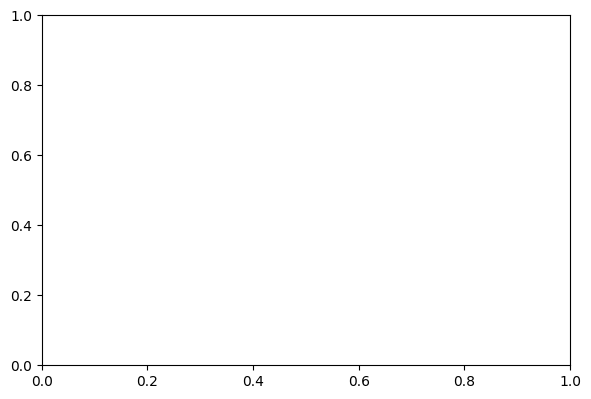

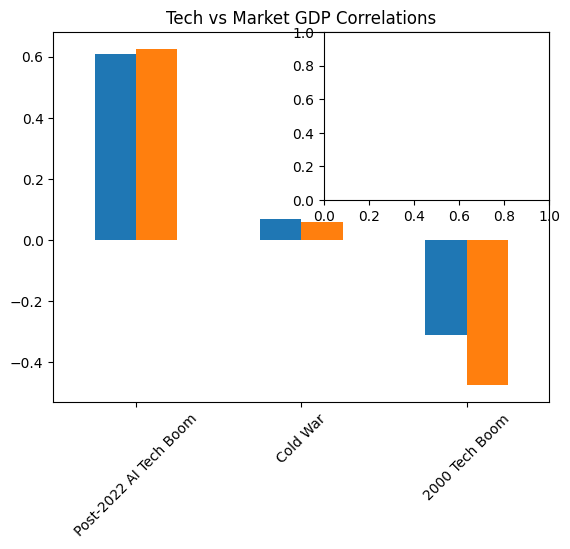

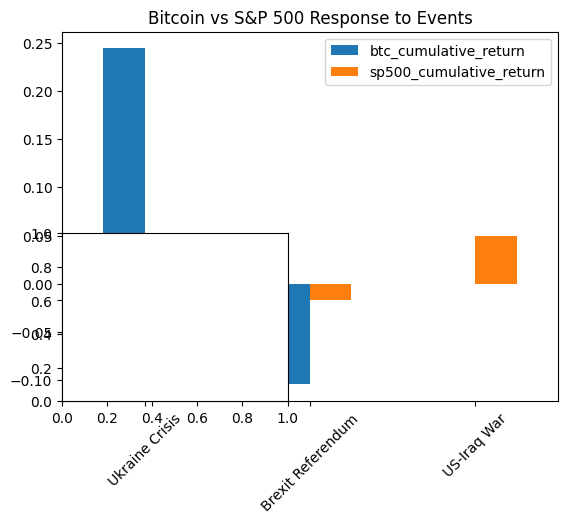

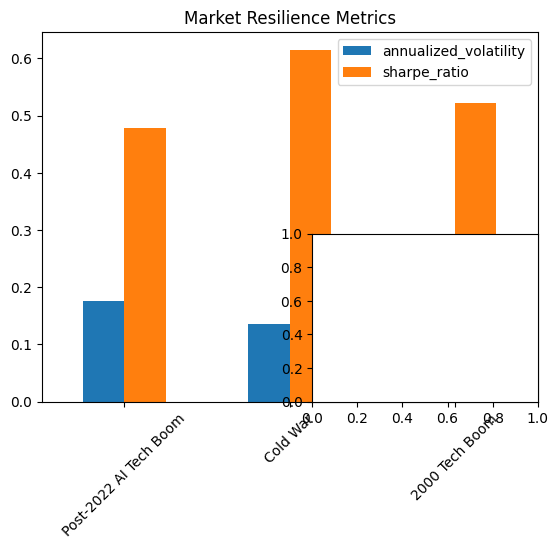

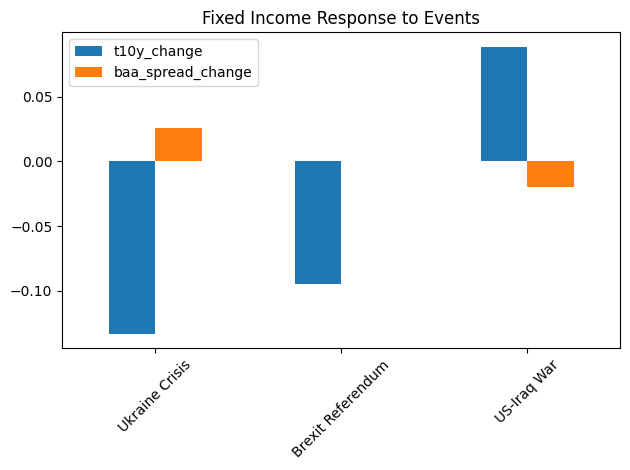

<Figure size 1000x600 with 0 Axes>

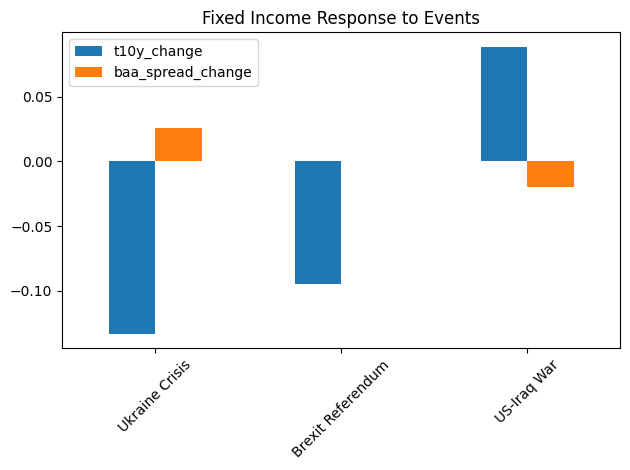

In [11]:
# Perform analysis
ai_war_impact = analyze_ai_vs_war_impact(df_yahoo_returns, df_fred, time_periods)

# Hypothesis 2: Bitcoin as a Geopolitical Risk Barometer
bitcoin_response = analyze_bitcoin_response(df_yahoo_returns, geopolitical_events)

# Hypothesis 3: Market Resilience During Conflict
market_resilience = analyze_market_resilience(df_yahoo, df_fred, time_periods)

# Hypothesis 4: Geopolitical Risk Premium in Fixed Income
fixed_income_sensitivity = analyze_fixed_income_sensitivity(df_yahoo, df_fred, geopolitical_events)

# Hypothesis 5: Liquidity Indicators and War Risks
#liquidity_impact = analyze_liquidity_impact(df_fred, geopolitical_events)

# Plot all results
plot_results(ai_war_impact, bitcoin_response, market_resilience, fixed_income_sensitivity)#, liquidity_impact)
